In [1]:
import sys
import math
import random
import itertools
import numpy as np
from gurobipy import *
from gurobipy import Model, GRB, quicksum
import pandas as pd
import time
import json

In [2]:
import openrouteservice as ors

In [3]:
# Open Route Service API
ors_key = "YOUR_API_KEY"

client = ors.Client(key=ors_key)

In [4]:
customer = pd.read_excel('/Users/syahrulappledeveloperbinus/Documents/CVRP/logistics_data.xlsx', 
                     sheet_name='customer', engine='openpyxl')

small_customer = customer[10:15]
customer.head()

,no,osmid,highway,long,lat,demand
0,1,2524302491,primary,110.368545,-7.822212,5
1,2,3256672772,primary,110.366040,-7.814581,8
2,3,3487503058,primary,110.367964,-7.821110,5
3,4,3636373134,primary,110.368241,-7.818550,5
4,5,3662449263,primary,110.368112,-7.819845,5


In [5]:
satellite = pd.read_excel('/Users/syahrulappledeveloperbinus/Documents/CVRP/logistics_data.xlsx', 
                     sheet_name='satellite', engine='openpyxl')
satellite.head()

,no,satellite,long,lat,note
0,1,Terminal Giwangan,110.392422,-7.833466,CDC
1,2,Museum Biologi,110.374012,-7.801582,satellite
2,3,Cik Di Tiro 2 (Dr. Yap),110.375282,-7.781738,satellite
3,4,RSUP dr. Sardjito,110.373570,-7.769080,satellite
4,5,Jl. Colombo (Panti Rapih),110.378555,-7.775746,satellite


In [6]:
# Setup CDC lat and long
cdc_lat = np.array(satellite.iloc[0].lat)
cdc_long = np.array(satellite.iloc[0].long)

In [7]:
n = customer.shape[0] # numbre of clients
xc = np.append(cdc_long, np.array(customer['long']))
yc = np.append(cdc_lat, np.array(customer['lat']))

In [8]:
# NOT USED DUE TO LIMIT QUOTA

"""
def distance_calculation_API(matrix_distance):
    distance_dict = {}
    for i, j in matrix_distance:
        time.sleep(0.5)
        distance_from_api = client.directions(coordinates=[[xc[i], yc[i]], [xc[j], yc[j]]],
                                                profile='driving-car',format='geojson')
        
        distance_only = distance_from_api['features'][0]['properties']['summary']['distance']
        distance_dict[(i, j)] = distance_only
        print("[INFO] Calculate distance between {0} and {1}".format((xc[i], yc[i]), (xc[j], yc[j])))
        
    return distance_dict
"""

'\ndef distance_calculation_API(matrix_distance):\n    distance_dict = {}\n    for i, j in matrix_distance:\n        time.sleep(0.5)\n        distance_from_api = client.directions(coordinates=[[xc[i], yc[i]], [xc[j], yc[j]]],\n                                                profile=\'driving-car\',format=\'geojson\')\n        \n        distance_only = distance_from_api[\'features\'][0][\'properties\'][\'summary\'][\'distance\']\n        distance_dict[(i, j)] = distance_only\n        print("[INFO] Calculate distance between {0} and {1}".format((xc[i], yc[i]), (xc[j], yc[j])))\n        \n    return distance_dict\n'

In [72]:
N = [i for i in range(1, n+1)] # total customers
V = [0] + N # add depot

A = [(i, j) for i in V for j in V if i != j] # matrix distance

# Using direction API to do distance calculation
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A} #distance calculation

# Save distance matrix 
with open(r'distance_matrix_cvrp.txt','w+') as f:
     f.write(str(c))

In [73]:
Q = 30 # vehicle capacity
q = {i: customer.demand[i-1] for i in N} # demand per customer

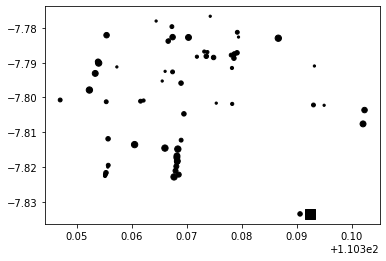

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(xc[0], yc[0], c='k', marker='s', s=100)
plt.scatter(xc[1:], yc[1:], c='k',  s=[x*5 for x in list(q.values())])

In [75]:
mdl = Model('CVRP')

In [76]:
x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)

In [77]:
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A))

In [78]:
mdl.addConstrs(quicksum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.addConstrs(quicksum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j])
               for i, j in A if i != 0 and j != 0)
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[i] <= Q for i in N)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>,
 22: <gurobi.Constr *Awaiting Model Update*

In [79]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 1500  # seconds
mdl.optimize()

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 1500.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 248 rows, 3968 columns and 7812 nonzeros
Model fingerprint: 0xa1df972b
Model has 3782 general constraints
Variable types: 62 continuous, 3906 integer (3906 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 6e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve added 9379 rows and 1939 columns
Presolve time: 0.29s
Presolved: 9627 rows, 5907 columns, 40871 nonzeros
Variable types: 1953 continuous, 3954 integer (3906 binary)

Root relaxation: objective 1.912011e-01, 316 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

H21087 13103                       0.9740521    0.23986  75.4%  25.4  238s
 21091 13334    0.31501  137  112    0.97405    0.23986  75.4%  25.4  240s
 22611 15117    0.62789  400   67    0.97405    0.23986  75.4%  25.9  246s
 23833 16167    0.83886  707   44    0.97405    0.23994  75.4%  25.8  250s
 25713 18286    0.43470  230  120    0.97405    0.23994  75.4%  26.0  256s
 27341 19879    0.55272  561   78    0.97405    0.23994  75.4%  25.8  260s
 29373 21943    0.93964  930   33    0.97405    0.24032  75.3%  25.5  265s
 30272 21944    0.56824  587  134    0.97405    0.24032  75.3%  25.4  338s
 30274 21945    0.39057  320  123    0.97405    0.24032  75.3%  25.4  341s
 30277 21947    0.82486 1460  153    0.97405    0.24032  75.3%  25.4  347s
 30278 21948    0.87301  292  149    0.97405    0.24032  75.3%  25.4  351s
 30279 21949    0.29123  130  163    0.97405    0.24032  75.3%  25.4  355s
 30281 21950    0.27644   87  157    0.97405    0.24032  75.3%  25.4  362s
 30282 21951    0.82654  

 89669 57694    0.41349  372   72    0.92241    0.24167  73.8%  29.5  780s
H91310 57805                       0.9218558    0.24167  73.8%  29.5  783s
 91328 58506    0.44961  447   94    0.92186    0.24167  73.8%  29.5  785s
 92713 59939    0.58308  567   80    0.92186    0.24167  73.8%  29.8  790s
 94781 62127    0.28506  174  131    0.92186    0.24168  73.8%  29.8  796s
 96340 63356    0.38868  416  109    0.92186    0.24168  73.8%  29.8  801s
 98073 65066    0.64571  882   73    0.92186    0.24194  73.8%  29.8  806s
 99781 66262    0.27234   89  143    0.92186    0.24203  73.7%  29.9  811s
H100635 66497                       0.9218387    0.24203  73.7%  30.0  813s
 100651 67091    0.31699  131  120    0.92184    0.24203  73.7%  30.0  816s
 102056 67910    0.35736  174  102    0.92184    0.24203  73.7%  30.0  823s
H102059 67734                       0.9164543    0.24203  73.6%  30.0  823s
 102064 68509    0.35123  172  106    0.91645    0.24203  73.6%  30.0  827s
H102915 69077       

 230784 190098    0.41094  148  107    0.90189    0.24323  73.0%  28.7 1281s
 231578 191650    0.47269  303   94    0.90189    0.24323  73.0%  28.7 1286s
 233325 193202    0.78265  677   65    0.90189    0.24324  73.0%  28.7 1290s
 235836 195611    0.31103  176  137    0.90189    0.24325  73.0%  28.7 1296s
 237261 197290    0.36352  340  137    0.90189    0.24325  73.0%  28.7 1303s
 238378 197917    0.39324  477  120    0.90189    0.24325  73.0%  28.7 1305s
 239737 198557    0.64264  710   79    0.90189    0.24325  73.0%  28.8 1312s
 240645 199961    0.69557  866   77    0.90189    0.24325  73.0%  28.8 1316s
 242292 201697    0.88447 1176   56    0.90189    0.24326  73.0%  28.8 1321s
 243489 203144    0.27886  111  131    0.90189    0.24326  73.0%  28.8 1326s
 245163 203895    0.37627  295  113    0.90189    0.24326  73.0%  28.8 1331s
 246568 206567    0.46780  537   98    0.90189    0.24326  73.0%  28.7 1337s
 248761 208566    0.85707  930   28    0.90189    0.24331  73.0%  28.6 1342s

In [80]:
active_arcs = [a for a in A if x[a].x > 0.99]

In [81]:
arcs_dict = {}
for idx, arc in enumerate(active_arcs):
    if (arc[0] == 0):
        arcs_dict[idx] = [arc]

arcs_dict

{0: [(0, 9)],
 1: [(0, 12)],
 2: [(0, 13)],
 3: [(0, 17)],
 4: [(0, 20)],
 5: [(0, 23)],
 6: [(0, 42)],
 7: [(0, 48)],
 8: [(0, 51)]}

In [82]:
for key in arcs_dict:
    first_point = arcs_dict[key][0][0]
    
    for step in range(len(active_arcs)):
        try:
            next_point = arcs_dict[key][step][1]
            
            for idx, arc in enumerate(active_arcs):
                if (next_point == arc[0] and next_point != first_point):
                    arcs_dict[key].append(arc)

        except IndexError:
            pass

In [62]:
# Add arrow to line
def add_arrow(line, position=None, direction='right', size=30, color=None):

    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

Text(0.5, 1.0, 'VCRP Solution Map')

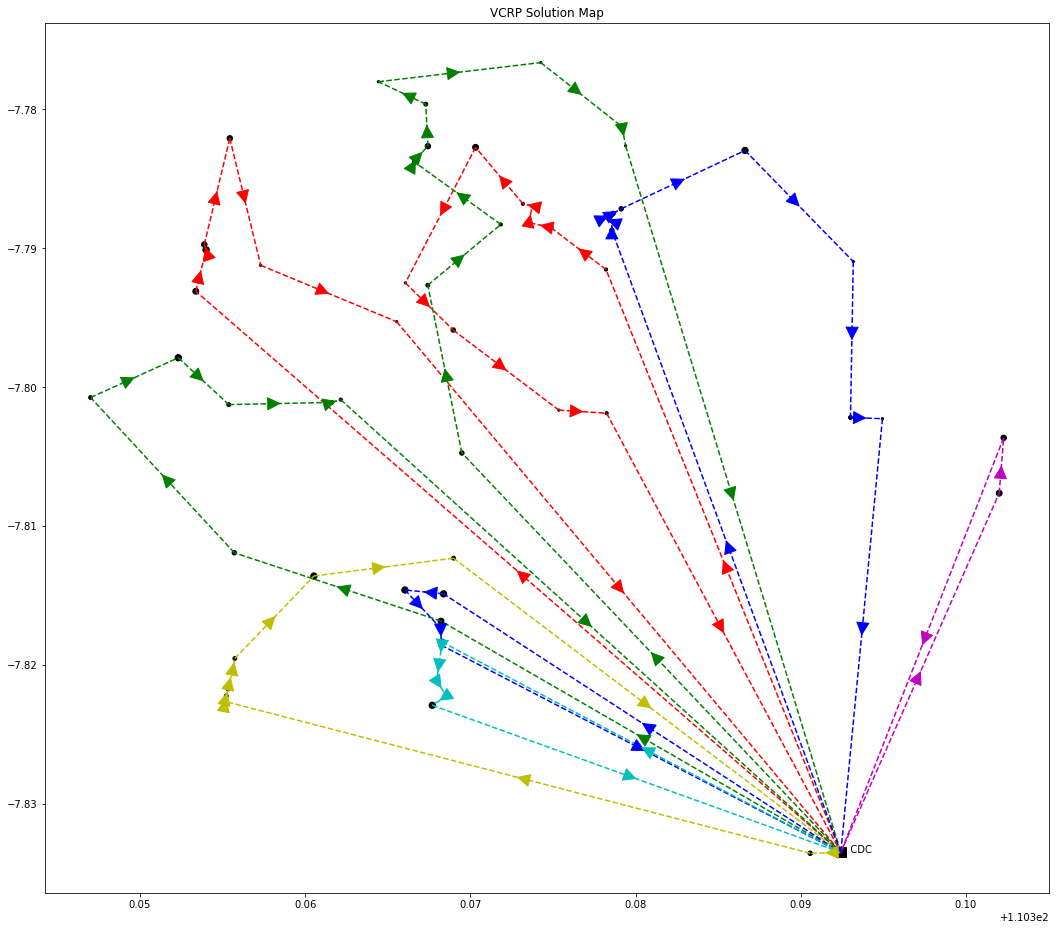

In [83]:
line_colors = ['r--', 'g--', 'b--', 'c--', 'm--', 'y--'] * 5

plt.figure(figsize=(18,16))
for key, value in arcs_dict.items():
    for i, j in value:
        x = np.linspace(xc[i], xc[j], 100)
        y = np.linspace(yc[i], yc[j], 100)
        line = plt.plot(x, y, line_colors[key])[0]
        add_arrow(line)

plt.scatter(xc[0], yc[0], c='k', marker='s', s=100)
plt.text(xc[0], yc[0], s="   CDC")
plt.scatter(xc[1:], yc[1:], c='k', s=[x*5 for x in list(q.values())])
plt.title("VCRP Solution Map")

In [84]:
import folium
from branca.element import Figure

In [85]:
coords_dict = {}
for idx, arc in enumerate(active_arcs):
    if (arc[0] == 0):
        coords_dict[idx] = [arc[0],  arc[1]]

for key in coords_dict:
    first_point = coords_dict[key][0]
    
    for step in range(len(active_arcs)):
        try:
            next_point = coords_dict[key][step]

            for idx, arc in enumerate(active_arcs):
                if (next_point == arc[0] and next_point != 0):
                    coords_dict[key].append(arc[1])

        except IndexError:
            pass

coords_dict

{0: [0, 9, 10, 8, 18, 29, 39, 0],
 1: [0, 12, 36, 47, 19, 46, 27, 30, 0],
 2: [0, 13, 2, 15, 4, 0],
 3: [0, 17, 5, 3, 1, 14, 0],
 4: [0, 20, 21, 0],
 5: [0, 23, 25, 35, 44, 41, 34, 11, 33, 0],
 6: [0, 42, 40, 61, 55, 22, 6, 59, 45, 38, 62, 0],
 7: [0, 48, 32, 50, 56, 31, 16, 57, 43, 58, 60, 37, 0],
 8: [0, 51, 52, 49, 54, 53, 7, 26, 28, 24, 0]}

In [86]:
latlong_coord_dict = {}
longlat_coord_dict = {}

for key, value in coords_dict.items():
    latlong_path = []
    longlat_path = []
    for step in value:
        latlong_path.append([yc[step], xc[step]])
        longlat_path.append([xc[step], yc[step]])
        
    latlong_coord_dict[key] = latlong_path
    longlat_coord_dict[key] = longlat_path

In [87]:
# ALERT: THIS CELL WANT TO CALL API

routes_dict = {}
total_distances_dict = {}

for key, value in latlong_coord_dict.items():
    time.sleep(0.5)
    
    direction_api = client.directions(coordinates=longlat_coord_dict[key],
                          profile='driving-car', format='geojson')
    
    coords = direction_api['features'][0]['geometry']['coordinates']
    
    routes_dict[key] = [[coord[1], coord[0]] for coord in coords]
    total_distances_dict[key] = direction_api['features'][0]['properties']['summary']['distance']

print("[INFO] Done calculate from API ...")

[INFO] Done calculate from API ...


In [88]:
# Save Routes & Total distance from API
with open('routes_cvrp_12.json', 'w') as fp:
    json.dump(routes_dict, fp)

with open('total_distances_cvrp_12.json', 'w') as fp:
    json.dump(total_distances_dict, fp)
    
print("[INFO] Done saving routes and total distances ...")

[INFO] Done saving routes and total distances ...


In [89]:
# Jarak rute tempuh masing2 rute dalam meter
total_distances_dict

{0: 22354.2,
 1: 19334.8,
 2: 12709.8,
 3: 11572.1,
 4: 9199.6,
 5: 15247.6,
 6: 19599.8,
 7: 32141.8,
 8: 17597.6}

In [31]:
# Jogja City Map
jogja_map = folium.Map(location=[-7.797068, 110.370529], zoom_start=12)

# Creating feature groups
cargo1 = folium.FeatureGroup("Cargo 1")
cargo2 = folium.FeatureGroup("Cargo 2")
cargo3 = folium.FeatureGroup("Cargo 3")
cargo4 = folium.FeatureGroup("Cargo 4")
cargo5 = folium.FeatureGroup("Cargo 5")

# Create marker
folium.Marker(location=latlong_coord_dict[0][0],popup='CDC',tooltip='<strong>Click here to see Popup</strong>',icon=folium.Icon(color='black',icon='none')).add_to(jogja_map)

In [131]:
marker_colors = ['red', 'green', 'darkblue', 'lightblue', 'purple', 'orange'] * 3

# Add others marker
for key, value in coords_dict.items():
    color = marker_colors[key]
    tooltip = '<strong>Click to see Popup</strong>'
    
    for step in range(1, len(value)-1):
        popup = 'Cargo {0} - Destination {1}'.format(key+1, step)
        
        folium.Marker(location=latlong_coord_dict[key][step],popup=popup,tooltip=tooltip,icon=folium.Icon(color=color,icon='none')).add_to(jogja_map)
    

In [132]:
# Adding lines to the different feature groups
route_line1 = folium.vector_layers.PolyLine(routes_dict[0], popup='<b>Path of Cargo_1</b>',tooltip='Cargo_1',color='red',weight=4).add_to(cargo1)
route_line2 = folium.vector_layers.PolyLine(routes_dict[1], popup='<b>Path of Cargo_2</b>',tooltip='Cargo_2',color='green',weight=4).add_to(cargo2)
route_line3 = folium.vector_layers.PolyLine(routes_dict[2], popup='<b>Path of Cargo_3</b>',tooltip='Cargo_3',color='blue',weight=4).add_to(cargo3)
route_line4 = folium.vector_layers.PolyLine(routes_dict[3], popup='<b>Path of Cargo_3</b>',tooltip='Cargo_3',color='lightblue',weight=4).add_to(cargo4)
route_line5 = folium.vector_layers.PolyLine(routes_dict[4], popup='<b>Path of Cargo_3</b>',tooltip='Cargo_3',color='purple',weight=4).add_to(cargo5)

cargo1.add_to(jogja_map)
cargo2.add_to(jogja_map)
cargo3.add_to(jogja_map)
cargo4.add_to(jogja_map)
cargo5.add_to(jogja_map)

folium.LayerControl().add_to(jogja_map)

# Show the map
jogja_map

In [90]:
sum_total_distance = 0

# Total keseluruhan jarak tempuh
for key, value in total_distances_dict.items():
    sum_total_distance += value
    
print(sum_total_distance)

159757.30000000002


---